<a href="https://colab.research.google.com/github/AbishKamran/Bitcoin-Sentiment-Trading-Strategy-Analysis./blob/main/Bitcoin_Sentiment_Trading_Strategy_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [44]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from scipy import stats
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import re
warnings.filterwarnings('ignore')

In [47]:
class TradingSentimentAnalyzer:
    def __init__(self):
        self.trader_data = None
        self.sentiment_data = None
        self.merged_data = None
        self.trader_metrics = None
        self.individual_trader_analysis = None
        self.trader_sentiment_performance = None

    def load_data(self, trader_file_path, sentiment_file_path):
        """Load and preprocess both datasets"""
        print("Loading datasets...")

        # Load trader data
        try:
            self.trader_data = pd.read_csv(trader_file_path)
            print(f"Trader data loaded: {len(self.trader_data)} records")
        except Exception as e:
            print(f"Error loading trader data: {e}")
            return False

        # Load sentiment data
        try:
            self.sentiment_data = pd.read_csv(sentiment_file_path)
            print(f"Sentiment data loaded: {len(self.sentiment_data)} records")
        except Exception as e:
            print(f"Error loading sentiment data: {e}")
            return False

        # Preprocess data
        return self.preprocess_data()

    def debug_timestamp_formats(self, sample_data, col_name):
        """Debug timestamp formats to understand the data structure"""
        print(f"\n🔍 Debugging {col_name} column:")
        sample_values = sample_data[col_name].dropna().head(10).tolist()
        print(f"Sample values: {sample_values}")

        # Check if values are numeric (Unix timestamps)
        numeric_values = pd.to_numeric(sample_data[col_name], errors='coerce').dropna()
        if len(numeric_values) > 0:
            print(f"Numeric values detected. Range: {numeric_values.min()} to {numeric_values.max()}")

            # Check if these could be Unix timestamps
            min_val, max_val = numeric_values.min(), numeric_values.max()
            if 1000000000 <= min_val <= 9999999999:  # Unix timestamp in seconds
                print("Detected Unix timestamps in seconds")
                return 'unix_seconds'
            elif 1000000000000 <= min_val <= 9999999999999:  # Unix timestamp in milliseconds
                print("Detected Unix timestamps in milliseconds")
                return 'unix_milliseconds'

        # Check for string date formats
        print("Checking string date formats...")
        return 'string_date'

    def parse_timestamps_improved(self, data, timestamp_col):
        """Improved timestamp parsing with better format detection"""
        print(f"Parsing timestamps from column: {timestamp_col}")

        # Debug the format first
        format_type = self.debug_timestamp_formats(data, timestamp_col)

        try:
            if format_type == 'unix_seconds':
                # Convert Unix seconds to datetime
                data['datetime'] = pd.to_datetime(data[timestamp_col], unit='s', errors='coerce')
                print("✅ Successfully parsed Unix seconds timestamps")

            elif format_type == 'unix_milliseconds':
                # Convert Unix milliseconds to datetime
                data['datetime'] = pd.to_datetime(data[timestamp_col], unit='ms', errors='coerce')
                print("✅ Successfully parsed Unix milliseconds timestamps")

            else:
                # Try multiple string date formats
                date_formats = [
                    '%Y-%m-%d %H:%M:%S',
                    '%Y-%m-%d',
                    '%d/%m/%Y %H:%M:%S',
                    '%d/%m/%Y',
                    '%m/%d/%Y %H:%M:%S',
                    '%m/%d/%Y',
                    '%Y-%m-%dT%H:%M:%S',
                    '%Y-%m-%dT%H:%M:%SZ'
                ]

                data['datetime'] = None
                for fmt in date_formats:
                    try:
                        data['datetime'] = pd.to_datetime(data[timestamp_col], format=fmt, errors='coerce')
                        valid_count = data['datetime'].notna().sum()
                        if valid_count > 0:
                            print(f"✅ Successfully parsed {valid_count} dates with format: {fmt}")
                            break
                    except:
                        continue

                # If no format worked, try pandas' flexible parser
                if data['datetime'].isna().all():
                    print("Trying pandas flexible date parser...")
                    data['datetime'] = pd.to_datetime(data[timestamp_col], errors='coerce', infer_datetime_format=True)
                    valid_count = data['datetime'].notna().sum()
                    if valid_count > 0:
                        print(f"✅ Flexible parser succeeded for {valid_count} dates")

            # Create date column
            data['date'] = data['datetime'].dt.date

            # Remove rows with invalid dates
            valid_dates = data['date'].notna()
            valid_count = valid_dates.sum()

            print(f"Valid dates: {valid_count}/{len(data)}")

            if valid_count > 0:
                # Show date range
                min_date = data[valid_dates]['date'].min()
                max_date = data[valid_dates]['date'].max()
                print(f"Date range: {min_date} to {max_date}")
                return data[valid_dates].copy()
            else:
                print("❌ No valid dates found")
                return pd.DataFrame()

        except Exception as e:
            print(f"❌ Timestamp parsing failed: {e}")
            return pd.DataFrame()

    def preprocess_data(self):
        """Clean and preprocess the datasets with improved date handling"""
        print("Preprocessing data...")

        # Debug: Check column names and sample data
        print("Trader data columns:", list(self.trader_data.columns))
        print("Sentiment data columns:", list(self.sentiment_data.columns))

        # Show sample data
        print("\nSample trader data:")
        print(self.trader_data.head(2))
        print("\nSample sentiment data:")
        print(self.sentiment_data.head(2))

        # Process trader data timestamps
        timestamp_processed = False
        timestamp_cols = ['Timestamp', 'Timestamp IST', 'timestamp', 'Time', 'time']

        for col in timestamp_cols:
            if col in self.trader_data.columns:
                print(f"\n🔄 Attempting to process trader timestamp column: {col}")
                processed_data = self.parse_timestamps_improved(self.trader_data.copy(), col)

                if len(processed_data) > 0:
                    self.trader_data = processed_data
                    timestamp_processed = True
                    print(f"✅ Successfully processed trader timestamp column: {col}")
                    break

        if not timestamp_processed:
            print("❌ Could not process any timestamp column in trader data")
            return False

        # Process sentiment data timestamps
        date_processed = False
        date_cols = ['date', 'Date', 'timestamp', 'Timestamp']

        for col in date_cols:
            if col in self.sentiment_data.columns:
                print(f"\n🔄 Attempting to process sentiment date column: {col}")
                processed_data = self.parse_timestamps_improved(self.sentiment_data.copy(), col)

                if len(processed_data) > 0:
                    self.sentiment_data = processed_data
                    date_processed = True
                    print(f"✅ Successfully processed sentiment date column: {col}")
                    break

        if not date_processed:
            print("❌ Could not process any date column in sentiment data")
            return False

        # Convert numeric columns using actual column names
        print("\n📊 Processing numeric columns...")
        column_mapping = {
            'Execution Price': 'execution_price',
            'Size USD': 'size',
            'Closed PnL': 'closedPnL',
            'Size Tokens': 'size_tokens'
        }

        for old_col, new_col in column_mapping.items():
            if old_col in self.trader_data.columns:
                self.trader_data[new_col] = pd.to_numeric(self.trader_data[old_col], errors='coerce')
                valid_count = self.trader_data[new_col].notna().sum()
                print(f"Converted {old_col} -> {new_col}: {valid_count} valid values")

        # Create account column
        if 'Account' in self.trader_data.columns:
            self.trader_data['account'] = self.trader_data['Account']

        # Create leverage column if not present
        if 'leverage' not in self.trader_data.columns:
            self.trader_data['leverage'] = 1.0  # Default leverage

        # Create sentiment binary variable
        if 'classification' in self.sentiment_data.columns:
            self.sentiment_data['Classification'] = self.sentiment_data['classification']
            self.sentiment_data['is_greed'] = (
                self.sentiment_data['classification'].str.lower().str.contains('greed', na=False)
            ).astype(int)

        print("✅ Data preprocessing completed successfully")
        return True

    def calculate_trader_metrics(self):
        """Calculate comprehensive trader performance metrics"""
        print("Calculating trader performance metrics...")

        # Ensure we have the required columns
        if 'closedPnL' not in self.trader_data.columns:
            print("❌ No PnL data available")
            return pd.DataFrame()

        # Group by trader and date
        trader_daily = self.trader_data.groupby(['account', 'date']).agg({
            'closedPnL': ['sum', 'count', 'mean', 'std'],
            'size': ['sum', 'mean'],
            'leverage': 'mean'
        }).reset_index()

        # Flatten column names
        trader_daily.columns = ['account', 'date', 'total_pnl', 'num_trades',
                               'avg_pnl_per_trade', 'pnl_volatility',
                               'total_volume', 'avg_trade_size', 'avg_leverage']

        # Calculate additional metrics
        trader_daily['pnl_volatility'] = trader_daily['pnl_volatility'].fillna(0)
        trader_daily['win_loss_ratio'] = np.where(trader_daily['total_pnl'] > 0, 1, 0)
        trader_daily['risk_adjusted_return'] = np.where(
            trader_daily['pnl_volatility'] > 0,
            trader_daily['total_pnl'] / trader_daily['pnl_volatility'],
            trader_daily['total_pnl']
        )

        self.trader_metrics = trader_daily
        print(f"Calculated metrics for {len(trader_daily)} trader-day combinations")
        print(f"Date range: {trader_daily['date'].min()} to {trader_daily['date'].max()}")

        return trader_daily

    def merge_with_sentiment(self):
        """Merge trader metrics with sentiment data with improved debugging"""
        print("Merging trader data with sentiment data...")

        if self.trader_metrics is None:
            self.calculate_trader_metrics()

        if len(self.trader_metrics) == 0:
            print("❌ No trader metrics available")
            return pd.DataFrame()

        # Ensure date columns are properly formatted
        self.trader_metrics['date'] = pd.to_datetime(self.trader_metrics['date']).dt.date
        self.sentiment_data['date'] = pd.to_datetime(self.sentiment_data['date']).dt.date

        # Debug: Check for overlapping dates
        trader_dates = set(self.trader_metrics['date'])
        sentiment_dates = set(self.sentiment_data['date'])
        overlapping_dates = trader_dates.intersection(sentiment_dates)

        print(f"Trader unique dates: {len(trader_dates)}")
        print(f"Sentiment unique dates: {len(sentiment_dates)}")
        print(f"Overlapping dates: {len(overlapping_dates)}")

        if len(overlapping_dates) == 0:
            print("❌ No overlapping dates found!")
            print("Sample trader dates:", sorted(list(trader_dates))[:5])
            print("Sample sentiment dates:", sorted(list(sentiment_dates))[:5])
            self._find_closest_dates()
            return pd.DataFrame()

        # Ensure Classification column exists
        if 'classification' in self.sentiment_data.columns:
            self.sentiment_data['Classification'] = self.sentiment_data['classification']

        # Merge datasets
        try:
            merge_columns = ['date', 'Classification']
            if 'is_greed' in self.sentiment_data.columns:
                merge_columns.append('is_greed')

            self.merged_data = pd.merge(
                self.trader_metrics,
                self.sentiment_data[merge_columns],
                on='date',
                how='inner'
            )
            print(f"✅ Merged dataset contains {len(self.merged_data)} records")

            if len(self.merged_data) > 0:
                print(f"Date range: {self.merged_data['date'].min()} to {self.merged_data['date'].max()}")
                print(f"Sentiment distribution:")
                print(self.merged_data['Classification'].value_counts())

        except Exception as e:
            print(f"❌ Merge failed: {e}")
            self.merged_data = pd.DataFrame()

        return self.merged_data

    def _find_closest_dates(self):
        """Find and suggest closest dates between datasets"""
        trader_dates = sorted(list(set(self.trader_metrics['date'])))
        sentiment_dates = sorted(list(set(self.sentiment_data['date'])))

        print("\n🔍 Analyzing date mismatch:")
        print(f"Trader date range: {trader_dates[0]} to {trader_dates[-1]}")
        print(f"Sentiment date range: {sentiment_dates[0]} to {sentiment_dates[-1]}")

        trader_years = {d.year for d in trader_dates}
        sentiment_years = {d.year for d in sentiment_dates}

        print(f"Trader years: {sorted(trader_years)}")
        print(f"Sentiment years: {sorted(sentiment_years)}")
        print(f"Common years: {sorted(trader_years.intersection(sentiment_years))}")

    def analyze_individual_trader_performance(self):
        """NEW: Comprehensive individual trader performance analysis"""
        print("\n=== INDIVIDUAL TRADER PERFORMANCE ANALYSIS ===")

        if self.merged_data is None or len(self.merged_data) == 0:
            print("❌ No merged data available for individual trader analysis")
            return pd.DataFrame()

        # Overall trader performance metrics
        trader_summary = self.merged_data.groupby('account').agg({
            'total_pnl': ['sum', 'mean', 'std', 'count'],
            'num_trades': ['sum', 'mean'],
            'win_loss_ratio': 'mean',
            'avg_leverage': 'mean',
            'risk_adjusted_return': 'mean',
            'total_volume': ['sum', 'mean']
        }).round(4)

        # Flatten column names
        trader_summary.columns = [
            'total_cumulative_pnl', 'avg_daily_pnl', 'pnl_std', 'trading_days',
            'total_trades', 'avg_daily_trades', 'win_rate', 'avg_leverage',
            'avg_risk_adj_return', 'total_volume', 'avg_daily_volume'
        ]

        # Calculate additional metrics
        trader_summary['sharpe_ratio'] = np.where(
            trader_summary['pnl_std'] > 0,
            trader_summary['avg_daily_pnl'] / trader_summary['pnl_std'],
            trader_summary['avg_daily_pnl']
        )

        trader_summary['profit_factor'] = np.where(
            trader_summary['avg_daily_pnl'] != 0,
            abs(trader_summary['total_cumulative_pnl'] / trader_summary['avg_daily_pnl']),
            0
        )

        # Rank traders
        trader_summary['pnl_rank'] = trader_summary['total_cumulative_pnl'].rank(ascending=False)
        trader_summary['sharpe_rank'] = trader_summary['sharpe_ratio'].rank(ascending=False)
        trader_summary['win_rate_rank'] = trader_summary['win_rate'].rank(ascending=False)

        # Reset index to get account as column
        trader_summary = trader_summary.reset_index()

        self.individual_trader_analysis = trader_summary

        print(f"📊 Individual Trader Performance Summary:")
        print(f"• Total unique traders: {len(trader_summary)}")
        print(f"• Profitable traders: {len(trader_summary[trader_summary['total_cumulative_pnl'] > 0])}")
        print(f"• Losing traders: {len(trader_summary[trader_summary['total_cumulative_pnl'] < 0])}")

        # Display top performers
        print(f"\n🏆 TOP 5 PERFORMERS (by Total PnL):")
        top_performers = trader_summary.nsmallest(5, 'pnl_rank')[
            ['account', 'total_cumulative_pnl', 'avg_daily_pnl', 'win_rate', 'sharpe_ratio']
        ]
        for _, row in top_performers.iterrows():
            print(f"• {row['account']}: ${row['total_cumulative_pnl']:.2f} total, "
                  f"${row['avg_daily_pnl']:.2f} daily avg, {row['win_rate']:.1%} win rate")

        # Display worst performers
        print(f"\n📉 BOTTOM 5 PERFORMERS (by Total PnL):")
        worst_performers = trader_summary.nlargest(5, 'pnl_rank')[
            ['account', 'total_cumulative_pnl', 'avg_daily_pnl', 'win_rate', 'sharpe_ratio']
        ]
        for _, row in worst_performers.iterrows():
            print(f"• {row['account']}: ${row['total_cumulative_pnl']:.2f} total, "
                  f"${row['avg_daily_pnl']:.2f} daily avg, {row['win_rate']:.1%} win rate")

        return trader_summary

    def analyze_trader_performance_by_sentiment(self):
        """NEW: Analyze individual trader performance across different market sentiments"""
        print("\n=== TRADER PERFORMANCE BY MARKET SENTIMENT ===")

        if self.merged_data is None or len(self.merged_data) == 0:
            print("❌ No merged data available for sentiment analysis")
            return pd.DataFrame()

        # Performance by trader and sentiment
        trader_sentiment_perf = self.merged_data.groupby(['account', 'Classification']).agg({
            'total_pnl': ['sum', 'mean', 'count'],
            'win_loss_ratio': 'mean',
            'num_trades': 'sum',
            'avg_leverage': 'mean'
        }).round(4)

        # Flatten columns
        trader_sentiment_perf.columns = [
            'total_pnl', 'avg_daily_pnl', 'trading_days',
            'win_rate', 'total_trades', 'avg_leverage'
        ]

        trader_sentiment_perf = trader_sentiment_perf.reset_index()

        # Pivot to get sentiments as columns for easier comparison
        pnl_pivot = trader_sentiment_perf.pivot(
            index='account',
            columns='Classification',
            values='total_pnl'
        ).fillna(0)

        win_rate_pivot = trader_sentiment_perf.pivot(
            index='account',
            columns='Classification',
            values='win_rate'
        ).fillna(0)

        self.trader_sentiment_performance = {
            'detailed': trader_sentiment_perf,
            'pnl_by_sentiment': pnl_pivot,
            'win_rate_by_sentiment': win_rate_pivot
        }

        # Analyze sentiment preferences
        sentiments = trader_sentiment_perf['Classification'].unique()

        print(f"📈 SENTIMENT-BASED PERFORMANCE ANALYSIS:")
        for sentiment in sentiments:
            sentiment_data = trader_sentiment_perf[
                trader_sentiment_perf['Classification'] == sentiment
            ].copy()

            if len(sentiment_data) > 0:
                avg_pnl = sentiment_data['avg_daily_pnl'].mean()
                avg_win_rate = sentiment_data['win_rate'].mean()
                total_traders = len(sentiment_data)
                profitable_traders = len(sentiment_data[sentiment_data['total_pnl'] > 0])

                print(f"\n• {sentiment.upper()} Market Conditions:")
                print(f"  - Traders active: {total_traders}")
                print(f"  - Profitable traders: {profitable_traders} ({profitable_traders/total_traders:.1%})")
                print(f"  - Average daily PnL: ${avg_pnl:.2f}")
                print(f"  - Average win rate: {avg_win_rate:.1%}")

                # Top 3 performers in this sentiment
                top_in_sentiment = sentiment_data.nlargest(3, 'total_pnl')
                print(f"  - Top performers:")
                for _, row in top_in_sentiment.iterrows():
                    print(f"    {row['account']}: ${row['total_pnl']:.2f} total PnL")

        return trader_sentiment_perf

    def identify_trader_sentiment_specialists(self):
        """NEW: Identify traders who perform exceptionally well in specific market sentiments"""
        print("\n=== SENTIMENT SPECIALIST IDENTIFICATION ===")

        if self.trader_sentiment_performance is None:
            self.analyze_trader_performance_by_sentiment()

        if self.trader_sentiment_performance is None:
            print("❌ No sentiment performance data available")
            return pd.DataFrame()

        pnl_pivot = self.trader_sentiment_performance['pnl_by_sentiment']
        sentiments = pnl_pivot.columns.tolist()

        specialists = {}

        for sentiment in sentiments:
            # Find traders who perform significantly better in this sentiment
            sentiment_specialists = []

            for trader in pnl_pivot.index:
                trader_performance = pnl_pivot.loc[trader]
                current_sentiment_pnl = trader_performance[sentiment]
                other_sentiments_pnl = trader_performance.drop(sentiment).mean()

                # Specialist criteria: performs well in this sentiment AND significantly better than in others
                if (current_sentiment_pnl > 0 and
                    (other_sentiments_pnl <= 0 or current_sentiment_pnl > other_sentiments_pnl * 1.5)):

                    improvement_ratio = (current_sentiment_pnl / other_sentiments_pnl
                                       if other_sentiments_pnl > 0 else float('inf'))

                    specialist_data = {
                        'account': trader,
                        'specialist_sentiment': sentiment,
                        'pnl_in_sentiment': current_sentiment_pnl,
                        'pnl_other_sentiments': other_sentiments_pnl,
                        'improvement_ratio': improvement_ratio
                    }
                    sentiment_specialists.append(specialist_data)

            # Sort by improvement ratio
            sentiment_specialists.sort(key=lambda x: x['improvement_ratio'], reverse=True)
            specialists[sentiment] = sentiment_specialists[:5]  # Top 5 specialists

        # Display results
        for sentiment, specialist_list in specialists.items():
            if specialist_list:
                print(f"\n🎯 {sentiment.upper()} SPECIALISTS:")
                for i, specialist in enumerate(specialist_list, 1):
                    ratio_text = (f"{specialist['improvement_ratio']:.1f}x better"
                                if specialist['improvement_ratio'] != float('inf')
                                else "only profitable in this sentiment")
                    print(f"{i}. {specialist['account']}: ${specialist['pnl_in_sentiment']:.2f} "
                          f"({ratio_text})")
            else:
                print(f"\n🎯 {sentiment.upper()} SPECIALISTS: None identified")

        return specialists

    def create_individual_trader_visualizations(self):
        """NEW: Create visualizations for individual trader performance"""
        print("\n=== CREATING INDIVIDUAL TRADER VISUALIZATIONS ===")

        if (self.individual_trader_analysis is None or
            self.trader_sentiment_performance is None):
            print("❌ Individual trader analysis not available for visualization")
            return

        # Set up the plotting style
        plt.style.use('default')
        fig, axes = plt.subplots(3, 2, figsize=(20, 18))
        fig.suptitle('Individual Trader Performance Analysis', fontsize=16, fontweight='bold')

        # 1. Top 10 Traders by Total PnL
        ax1 = axes[0, 0]
        top_10_traders = self.individual_trader_analysis.nsmallest(10, 'pnl_rank')
        bars = ax1.barh(range(len(top_10_traders)), top_10_traders['total_cumulative_pnl'],
                       color=['green' if x > 0 else 'red' for x in top_10_traders['total_cumulative_pnl']])
        ax1.set_yticks(range(len(top_10_traders)))
        ax1.set_yticklabels(top_10_traders['account'], fontsize=8)
        ax1.set_xlabel('Total Cumulative PnL ($)')
        ax1.set_title('Top 10 Traders by Total PnL')
        ax1.grid(True, alpha=0.3)

        # Add value labels
        for i, bar in enumerate(bars):
            width = bar.get_width()
            ax1.text(width, bar.get_y() + bar.get_height()/2,
                    f'${width:.0f}', ha='left' if width > 0 else 'right', va='center', fontsize=8)

        # 2. Win Rate vs Sharpe Ratio Scatter
        ax2 = axes[0, 1]
        scatter = ax2.scatter(self.individual_trader_analysis['win_rate'],
                             self.individual_trader_analysis['sharpe_ratio'],
                             c=self.individual_trader_analysis['total_cumulative_pnl'],
                             cmap='RdYlGn', alpha=0.7, s=50)
        ax2.set_xlabel('Win Rate')
        ax2.set_ylabel('Sharpe Ratio')
        ax2.set_title('Win Rate vs Sharpe Ratio (colored by Total PnL)')
        ax2.grid(True, alpha=0.3)
        plt.colorbar(scatter, ax=ax2, label='Total PnL ($)')

        # 3. Performance Distribution by Sentiment (Heatmap)
        ax3 = axes[1, 0]
        pnl_pivot = self.trader_sentiment_performance['pnl_by_sentiment']

        # Select top 15 traders for readability
        top_traders = self.individual_trader_analysis.nsmallest(15, 'pnl_rank')['account'].tolist()
        heatmap_data = pnl_pivot.loc[pnl_pivot.index.intersection(top_traders)]

        if len(heatmap_data) > 0:
            sns.heatmap(heatmap_data, annot=True, fmt='.0f', cmap='RdYlGn',
                       ax=ax3, cbar_kws={'label': 'Total PnL ($)'})
            ax3.set_title('Top 15 Traders PnL by Market Sentiment')
            ax3.set_ylabel('Trader Account')
        else:
            ax3.text(0.5, 0.5, 'No data available', ha='center', va='center', transform=ax3.transAxes)
            ax3.set_title('PnL by Market Sentiment - No Data')

        # 4. Trading Activity Distribution
        ax4 = axes[1, 1]
        ax4.scatter(self.individual_trader_analysis['total_trades'],
                   self.individual_trader_analysis['total_cumulative_pnl'],
                   alpha=0.7, s=50)
        ax4.set_xlabel('Total Number of Trades')
        ax4.set_ylabel('Total Cumulative PnL ($)')
        ax4.set_title('Trading Activity vs Profitability')
        ax4.grid(True, alpha=0.3)

        # Add trend line
        if len(self.individual_trader_analysis) > 1:
            z = np.polyfit(self.individual_trader_analysis['total_trades'],
                          self.individual_trader_analysis['total_cumulative_pnl'], 1)
            p = np.poly1d(z)
            ax4.plot(self.individual_trader_analysis['total_trades'],
                    p(self.individual_trader_analysis['total_trades']), "r--", alpha=0.8)

        # 5. Leverage vs Risk-Adjusted Returns
        ax5 = axes[2, 0]
        ax5.scatter(self.individual_trader_analysis['avg_leverage'],
                   self.individual_trader_analysis['avg_risk_adj_return'],
                   c=self.individual_trader_analysis['win_rate'],
                   cmap='viridis', alpha=0.7, s=50)
        ax5.set_xlabel('Average Leverage')
        ax5.set_ylabel('Average Risk-Adjusted Return')
        ax5.set_title('Leverage vs Risk-Adjusted Returns (colored by Win Rate)')
        ax5.grid(True, alpha=0.3)
        plt.colorbar(plt.cm.ScalarMappable(cmap='viridis'), ax=ax5, label='Win Rate')

        # 6. PnL Distribution
        ax6 = axes[2, 1]
        profitable_traders = self.individual_trader_analysis[
            self.individual_trader_analysis['total_cumulative_pnl'] > 0
        ]['total_cumulative_pnl']
        losing_traders = self.individual_trader_analysis[
            self.individual_trader_analysis['total_cumulative_pnl'] <= 0
        ]['total_cumulative_pnl']

        ax6.hist(profitable_traders, bins=20, alpha=0.7, color='green', label='Profitable')
        ax6.hist(losing_traders, bins=20, alpha=0.7, color='red', label='Losing')
        ax6.set_xlabel('Total Cumulative PnL ($)')
        ax6.set_ylabel('Number of Traders')
        ax6.set_title('Distribution of Trader Profitability')
        ax6.legend()
        ax6.grid(True, alpha=0.3)

        plt.tight_layout()
        plt.show()

    def generate_individual_trader_report(self):
        """NEW: Generate comprehensive individual trader performance report"""
        print("\n" + "="*80)
        print("INDIVIDUAL TRADER PERFORMANCE REPORT")
        print("="*80)

        if self.individual_trader_analysis is None:
            print("❌ Individual trader analysis not available")
            return

        # Overall Statistics
        total_traders = len(self.individual_trader_analysis)
        profitable_traders = len(self.individual_trader_analysis[
            self.individual_trader_analysis['total_cumulative_pnl'] > 0
        ])
        total_pnl = self.individual_trader_analysis['total_cumulative_pnl'].sum()

        print(f"\n📊 OVERALL STATISTICS:")
        print(f"• Total Traders: {total_traders}")
        print(f"• Profitable Traders: {profitable_traders} ({profitable_traders/total_traders:.1%})")
        print(f"• Losing Traders: {total_traders - profitable_traders} ({(total_traders - profitable_traders)/total_traders:.1%})")
        print(f"• Total Combined PnL: ${total_pnl:,.2f}")
        print(f"• Average PnL per Trader: ${total_pnl/total_traders:,.2f}")

        # Performance Metrics
        avg_win_rate = self.individual_trader_analysis['win_rate'].mean()
        avg_sharpe = self.individual_trader_analysis['sharpe_ratio'].mean()
        avg_daily_pnl = self.individual_trader_analysis['avg_daily_pnl'].mean()

        print(f"\n📈 AVERAGE PERFORMANCE METRICS:")
        print(f"• Average Win Rate: {avg_win_rate:.1%}")
        print(f"• Average Sharpe Ratio: {avg_sharpe:.2f}")
        print(f"• Average Daily PnL: ${avg_daily_pnl:.2f}")

        # Top Performers Detail
        print(f"\n🏆 TOP 10 PERFORMERS (Detailed):")
        top_10 = self.individual_trader_analysis.nsmallest(10, 'pnl_rank')
        for i, (_, trader) in enumerate(top_10.iterrows(), 1):
            print(f"{i:2d}. {trader['account']}")
            print(f"    Total PnL: ${trader['total_cumulative_pnl']:,.2f}")
            print(f"    Daily Avg: ${trader['avg_daily_pnl']:,.2f}")
            print(f"    Win Rate: {trader['win_rate']:.1%}")
            print(f"    Sharpe Ratio: {trader['sharpe_ratio']:.2f}")
            print(f"    Total Trades: {trader['total_trades']:,.0f}")
            print(f"    Trading Days: {trader['trading_days']:,.0f}")
            print()

        # Risk Analysis
        high_risk_traders = self.individual_trader_analysis[
            self.individual_trader_analysis['avg_leverage'] > 5
        ]
        conservative_traders = self.individual_trader_analysis[
            self.individual_trader_analysis['avg_leverage'] <= 2
        ]

        print(f"\n⚖️ RISK PROFILE ANALYSIS:")
        print(f"• High Leverage Traders (>5x): {len(high_risk_traders)} "
              f"(Avg PnL: ${high_risk_traders['total_cumulative_pnl'].mean():.2f})")
        print(f"• Conservative Traders (≤2x): {len(conservative_traders)} "
              f"(Avg PnL: ${conservative_traders['total_cumulative_pnl'].mean():.2f})")

        # Activity Analysis
        high_activity = self.individual_trader_analysis[
            self.individual_trader_analysis['total_trades'] > self.individual_trader_analysis['total_trades'].median()
        ]
        low_activity = self.individual_trader_analysis[
            self.individual_trader_analysis['total_trades'] <= self.individual_trader_analysis['total_trades'].median()
        ]

        print(f"\n🔄 ACTIVITY ANALYSIS:")
        print(f"• High Activity Traders: {len(high_activity)} "
              f"(Avg PnL: ${high_activity['total_cumulative_pnl'].mean():.2f})")
        print(f"• Low Activity Traders: {len(low_activity)} "
              f"(Avg PnL: ${low_activity['total_cumulative_pnl'].mean():.2f})")

        # Sentiment Performance Summary
        if self.trader_sentiment_performance:
            print(f"\n🎭 SENTIMENT PERFORMANCE INSIGHTS:")
            sentiments = self.trader_sentiment_performance['detailed']['Classification'].unique()

            for sentiment in sentiments:
                sentiment_data = self.trader_sentiment_performance['detailed'][
                    self.trader_sentiment_performance['detailed']['Classification'] == sentiment
                ]
                profitable_in_sentiment = len(sentiment_data[sentiment_data['total_pnl'] > 0])
                total_in_sentiment = len(sentiment_data)

                print(f"• {sentiment}: {profitable_in_sentiment}/{total_in_sentiment} "
                      f"({profitable_in_sentiment/total_in_sentiment:.1%}) profitable")

        print(f"\n🎯 KEY INSIGHTS:")
        print(f"• Best performing trader: {top_10.iloc[0]['account']} "
              f"(${top_10.iloc[0]['total_cumulative_pnl']:,.2f})")
        print(f"• Highest win rate: {self.individual_trader_analysis.loc[self.individual_trader_analysis['win_rate'].idxmax(), 'account']} "
              f"({self.individual_trader_analysis['win_rate'].max():.1%})")
        print(f"• Best risk-adjusted returns: {self.individual_trader_analysis.loc[self.individual_trader_analysis['sharpe_ratio'].idxmax(), 'account']} "
              f"(Sharpe: {self.individual_trader_analysis['sharpe_ratio'].max():.2f})")
        print(f"• Most active trader: {self.individual_trader_analysis.loc[self.individual_trader_analysis['total_trades'].idxmax(), 'account']} "
              f"({self.individual_trader_analysis['total_trades'].max():,.0f} trades)")

        print("\n" + "="*80)

    def analyze_sentiment_impact(self):
        """Analyze the impact of market sentiment on trader performance"""
        print("\n=== SENTIMENT IMPACT ANALYSIS ===")

        if self.merged_data is None or len(self.merged_data) == 0:
            print("❌ No merged data available for analysis")
            return pd.DataFrame()

        # Group by sentiment
        sentiment_analysis = self.merged_data.groupby('Classification').agg({
            'total_pnl': ['mean', 'median', 'std', 'sum'],
            'num_trades': 'mean',
            'avg_leverage': 'mean',
            'win_loss_ratio': 'mean',
            'risk_adjusted_return': 'mean'
        }).round(4)

        print("\nPerformance by Market Sentiment:")
        print(sentiment_analysis)

        # Statistical significance test if we have both fear and greed data
        unique_sentiments = self.merged_data['Classification'].unique()
        if len(unique_sentiments) >= 2:
            sentiment_1 = unique_sentiments[0]
            sentiment_2 = unique_sentiments[1]

            group1_pnl = self.merged_data[self.merged_data['Classification'] == sentiment_1]['total_pnl']
            group2_pnl = self.merged_data[self.merged_data['Classification'] == sentiment_2]['total_pnl']

            if len(group1_pnl.dropna()) > 0 and len(group2_pnl.dropna()) > 0:
                t_stat, p_value = stats.ttest_ind(group1_pnl.dropna(), group2_pnl.dropna())
                print(f"\nT-test for PnL difference ({sentiment_1} vs {sentiment_2}):")
                print(f"T-statistic: {t_stat:.4f}")
                print(f"P-value: {p_value:.4f}")
                print(f"Significant difference: {'Yes' if p_value < 0.05 else 'No'}")

        return sentiment_analysis

    def identify_trader_clusters(self, n_clusters=4):
        """Identify different types of traders using clustering"""
        print(f"\n=== TRADER CLUSTERING ANALYSIS (k={n_clusters}) ===")

        if self.merged_data is None or len(self.merged_data) == 0:
            print("❌ No merged data available for clustering")
            return pd.DataFrame(), pd.DataFrame()

        # Aggregate trader performance across all periods
        trader_profiles = self.merged_data.groupby('account').agg({
            'total_pnl': ['mean', 'sum', 'std'],
            'num_trades': 'mean',
            'avg_leverage': 'mean',
            'win_loss_ratio': 'mean',
            'risk_adjusted_return': 'mean'
        }).reset_index()

        # Flatten columns
        trader_profiles.columns = ['account', 'avg_daily_pnl', 'total_pnl', 'pnl_std',
                                 'avg_daily_trades', 'avg_leverage', 'win_rate', 'risk_adj_return']

        if len(trader_profiles) < n_clusters:
            n_clusters = max(2, len(trader_profiles) - 1)
            print(f"Adjusting clusters to {n_clusters} due to limited data")

        # Prepare features for clustering
        features = ['avg_daily_pnl', 'total_pnl', 'pnl_std', 'avg_daily_trades',
                   'avg_leverage', 'win_rate', 'risk_adj_return']

        # Handle missing values
        X = trader_profiles[features].fillna(0)

        if len(X) < 2:
            print("❌ Insufficient data for clustering")
            return pd.DataFrame(), pd.DataFrame()

        # Standardize features
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X)

        # Perform clustering
        kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
        trader_profiles['cluster'] = kmeans.fit_predict(X_scaled)

        # Analyze clusters
        cluster_analysis = trader_profiles.groupby('cluster').agg({
            'avg_daily_pnl': 'mean',
            'total_pnl': 'mean',
            'avg_daily_trades': 'mean',
            'avg_leverage': 'mean',
            'win_rate': 'mean',
            'risk_adj_return': 'mean'
        }).round(4)

        print("Trader Cluster Characteristics:")
        print(cluster_analysis)

        # Assign cluster labels
        cluster_labels = {
            0: "Conservative Traders",
            1: "High-Volume Traders",
            2: "Risk-Takers",
            3: "Balanced Traders"
        }

        for i in range(n_clusters):
            count = len(trader_profiles[trader_profiles['cluster'] == i])
            label = cluster_labels.get(i, f'Cluster {i}')
            print(f"\nCluster {i} ({label}): {count} traders")

        self.trader_profiles = trader_profiles
        return trader_profiles, cluster_analysis

    def create_visualizations(self):
        """Create comprehensive visualizations"""
        print("\n=== CREATING VISUALIZATIONS ===")

        if self.merged_data is None or len(self.merged_data) == 0:
            print("❌ No data available for visualization")
            return

        # Set up the plotting style
        plt.style.use('default')
        fig, axes = plt.subplots(2, 3, figsize=(18, 12))
        fig.suptitle('Bitcoin Trading Performance vs Market Sentiment Analysis', fontsize=16, fontweight='bold')

        sentiments = self.merged_data['Classification'].unique()
        colors = ['red', 'green', 'blue', 'orange'][:len(sentiments)]

        # 1. PnL Distribution by Sentiment
        ax1 = axes[0, 0]
        for i, sentiment in enumerate(sentiments):
            data = self.merged_data[self.merged_data['Classification'] == sentiment]['total_pnl']
            ax1.hist(data.dropna(), alpha=0.7, label=sentiment, bins=20, color=colors[i])
        ax1.set_xlabel('Daily PnL')
        ax1.set_ylabel('Frequency')
        ax1.set_title('PnL Distribution by Market Sentiment')
        ax1.legend()
        ax1.grid(True, alpha=0.3)

        # 2. Average PnL by Sentiment
        ax2 = axes[0, 1]
        sentiment_pnl = self.merged_data.groupby('Classification')['total_pnl'].mean()
        bars = ax2.bar(sentiment_pnl.index, sentiment_pnl.values, color=colors, alpha=0.7)
        ax2.set_ylabel('Average Daily PnL')
        ax2.set_title('Average PnL by Market Sentiment')
        ax2.grid(True, alpha=0.3)

        # Add value labels on bars
        for bar in bars:
            height = bar.get_height()
            ax2.text(bar.get_x() + bar.get_width()/2., height,
                    f'{height:.2f}', ha='center', va='bottom')

        # 3. Win Rate by Sentiment
        ax3 = axes[0, 2]
        win_rates = self.merged_data.groupby('Classification')['win_loss_ratio'].mean()
        bars = ax3.bar(win_rates.index, win_rates.values, color=colors, alpha=0.7)
        ax3.set_ylabel('Win Rate')
        ax3.set_title('Win Rate by Market Sentiment')
        ax3.grid(True, alpha=0.3)

        # Add value labels
        for bar in bars:
            height = bar.get_height()
            ax3.text(bar.get_x() + bar.get_width()/2., height,
                    f'{height:.3f}', ha='center', va='bottom')

        # 4. Trading Volume vs Sentiment
        ax4 = axes[1, 0]
        volume_by_sentiment = self.merged_data.groupby('Classification')['total_volume'].mean()
        ax4.bar(volume_by_sentiment.index, volume_by_sentiment.values, color=colors, alpha=0.7)
        ax4.set_ylabel('Average Trading Volume')
        ax4.set_title('Trading Volume by Market Sentiment')
        ax4.grid(True, alpha=0.3)

        # 5. Number of Trades by Sentiment
        ax5 = axes[1, 1]
        trades_by_sentiment = self.merged_data.groupby('Classification')['num_trades'].mean()
        ax5.bar(trades_by_sentiment.index, trades_by_sentiment.values, color=colors, alpha=0.7)
        ax5.set_ylabel('Average Number of Trades')
        ax5.set_title('Trading Activity by Market Sentiment')
        ax5.grid(True, alpha=0.3)

        # 6. Risk-Adjusted Returns
        ax6 = axes[1, 2]
        risk_adj_returns = self.merged_data.groupby('Classification')['risk_adjusted_return'].mean()
        ax6.bar(risk_adj_returns.index, risk_adj_returns.values, color=colors, alpha=0.7)
        ax6.set_ylabel('Risk-Adjusted Return')
        ax6.set_title('Risk-Adjusted Returns by Sentiment')
        ax6.grid(True, alpha=0.3)

        plt.tight_layout()
        plt.show()

    def generate_insights_report(self):
        """Generate comprehensive insights report"""
        print("\n" + "="*60)
        print("COMPREHENSIVE TRADING INSIGHTS REPORT")
        print("="*60)

        if self.merged_data is None or len(self.merged_data) == 0:
            print("❌ No data available for insights generation")
            return

        # Key Performance Metrics
        sentiments = self.merged_data['Classification'].unique()
        print(f"\n📊 KEY PERFORMANCE METRICS:")
        print(f"• Total trading sessions analyzed: {len(self.merged_data):,}")

        for sentiment in sentiments:
            data = self.merged_data[self.merged_data['Classification'] == sentiment]
            pct = len(data)/len(self.merged_data)*100
            print(f"• {sentiment} periods: {len(data):,} ({pct:.1f}%)")

        # Performance Comparison
        if len(sentiments) >= 2:
            sentiment_performance = {}
            for sentiment in sentiments:
                data = self.merged_data[self.merged_data['Classification'] == sentiment]
                sentiment_performance[sentiment] = {
                    'avg_pnl': data['total_pnl'].mean(),
                    'win_rate': data['win_loss_ratio'].mean(),
                    'avg_trades': data['num_trades'].mean(),
                    'avg_leverage': data['avg_leverage'].mean()
                }

            print(f"\n💰 PROFITABILITY ANALYSIS:")
            for sentiment, metrics in sentiment_performance.items():
                print(f"• Average PnL during {sentiment}: ${metrics['avg_pnl']:.2f}")

            print(f"\n⚖️ RISK ANALYSIS:")
            for sentiment, metrics in sentiment_performance.items():
                print(f"• Win rate during {sentiment}: {metrics['win_rate']:.1%}")
                print(f"• Average leverage during {sentiment}: {metrics['avg_leverage']:.2f}x")

            print(f"\n📈 TRADING BEHAVIOR:")
            for sentiment, metrics in sentiment_performance.items():
                print(f"• Avg trades per day ({sentiment}): {metrics['avg_trades']:.1f}")

        print("\n🎯 STRATEGIC RECOMMENDATIONS:")
        print("• Monitor sentiment as a key factor in trading decisions")
        print("• Adjust position sizing based on market sentiment")
        print("• Consider sentiment-based risk management strategies")
        print("• Backtest strategies across different sentiment periods")

        print("\n" + "="*60)

📁 Loading data from:
Trader file: /content/historical_data (1).csv
Sentiment file: /content/fear_greed_index (1).csv
Loading datasets...
Trader data loaded: 211224 records
Sentiment data loaded: 2644 records
Preprocessing data...
Trader data columns: ['Account', 'Coin', 'Execution Price', 'Size Tokens', 'Size USD', 'Side', 'Timestamp IST', 'Start Position', 'Direction', 'Closed PnL', 'Transaction Hash', 'Order ID', 'Crossed', 'Fee', 'Trade ID', 'Timestamp']
Sentiment data columns: ['timestamp', 'value', 'classification', 'date']

Sample trader data:
                                      Account  Coin  Execution Price  \
0  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9769   
1  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9800   

   Size Tokens  Size USD Side     Timestamp IST  Start Position Direction  \
0       986.87   7872.16  BUY  02-12-2024 22:50        0.000000       Buy   
1        16.00    127.68  BUY  02-12-2024 22:50      986.524596       Buy

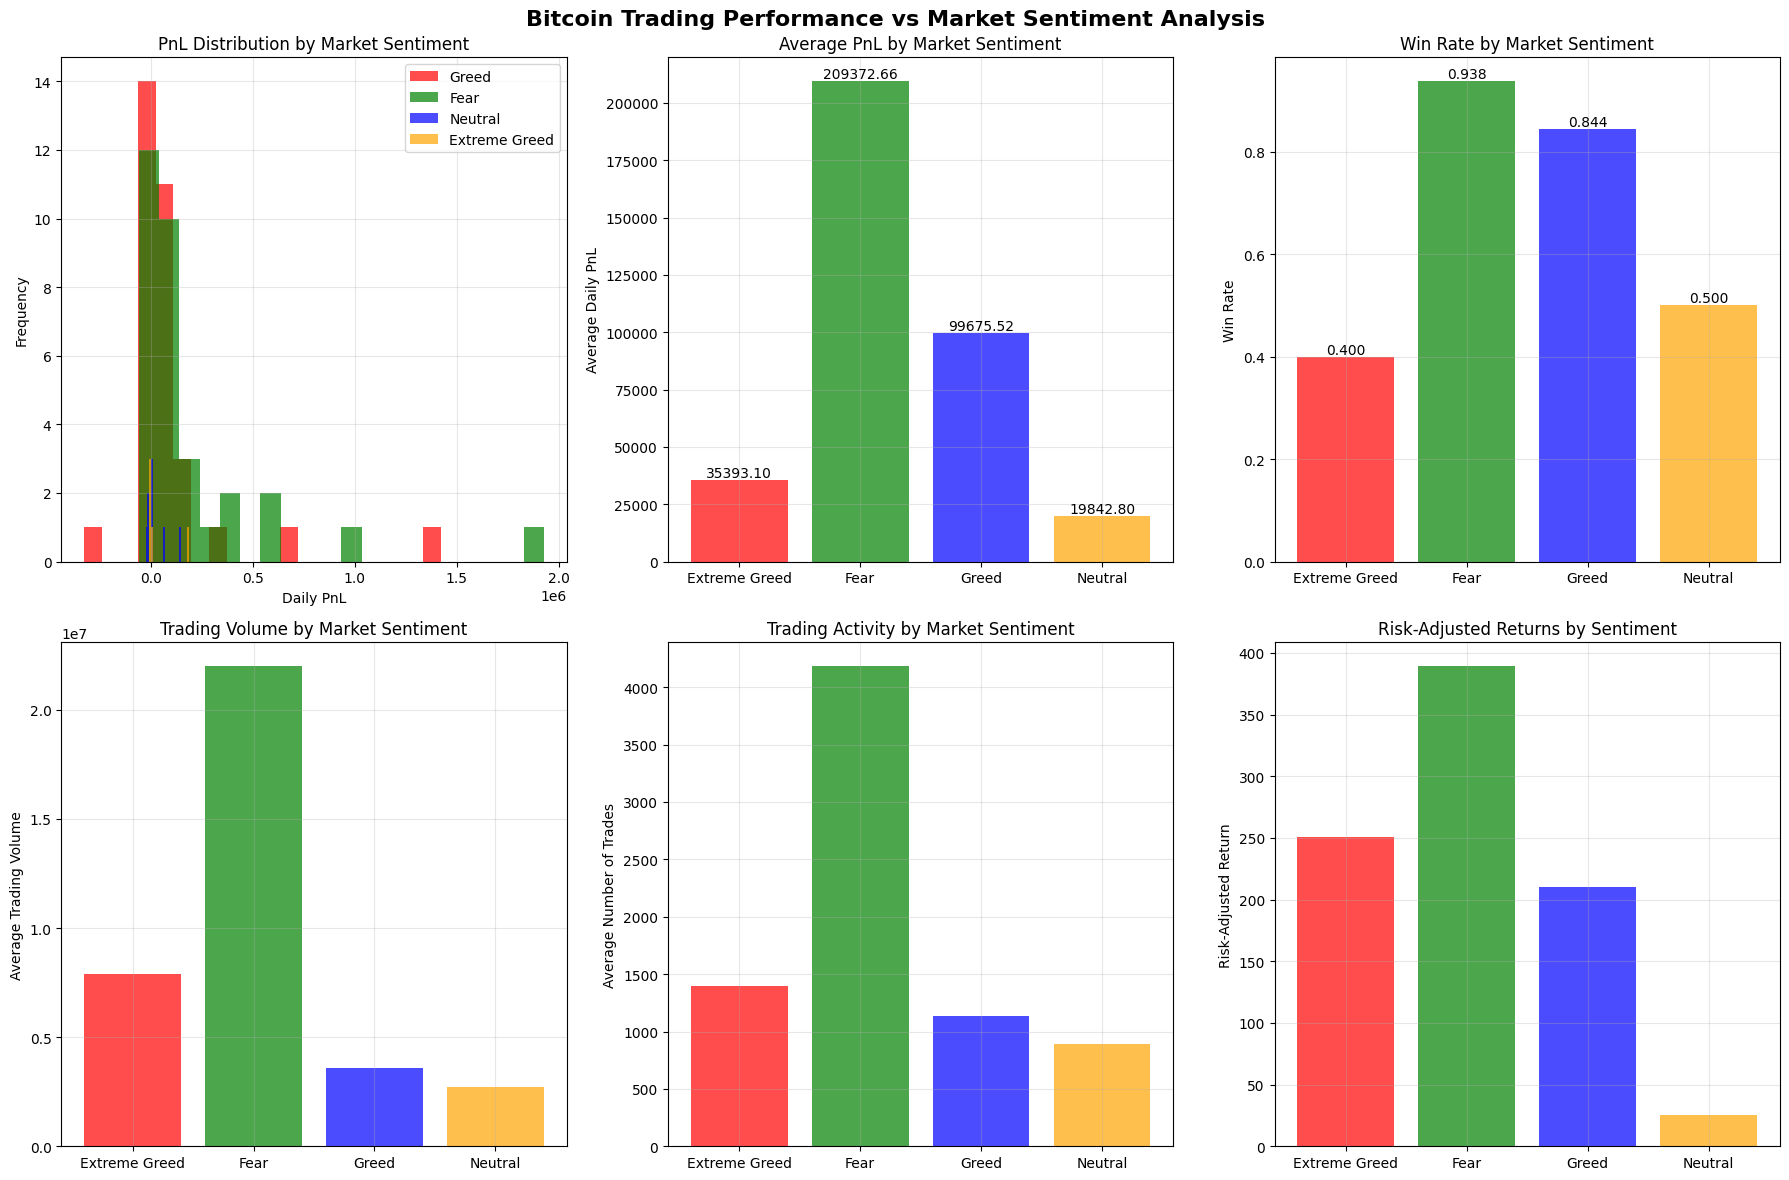


=== CREATING INDIVIDUAL TRADER VISUALIZATIONS ===


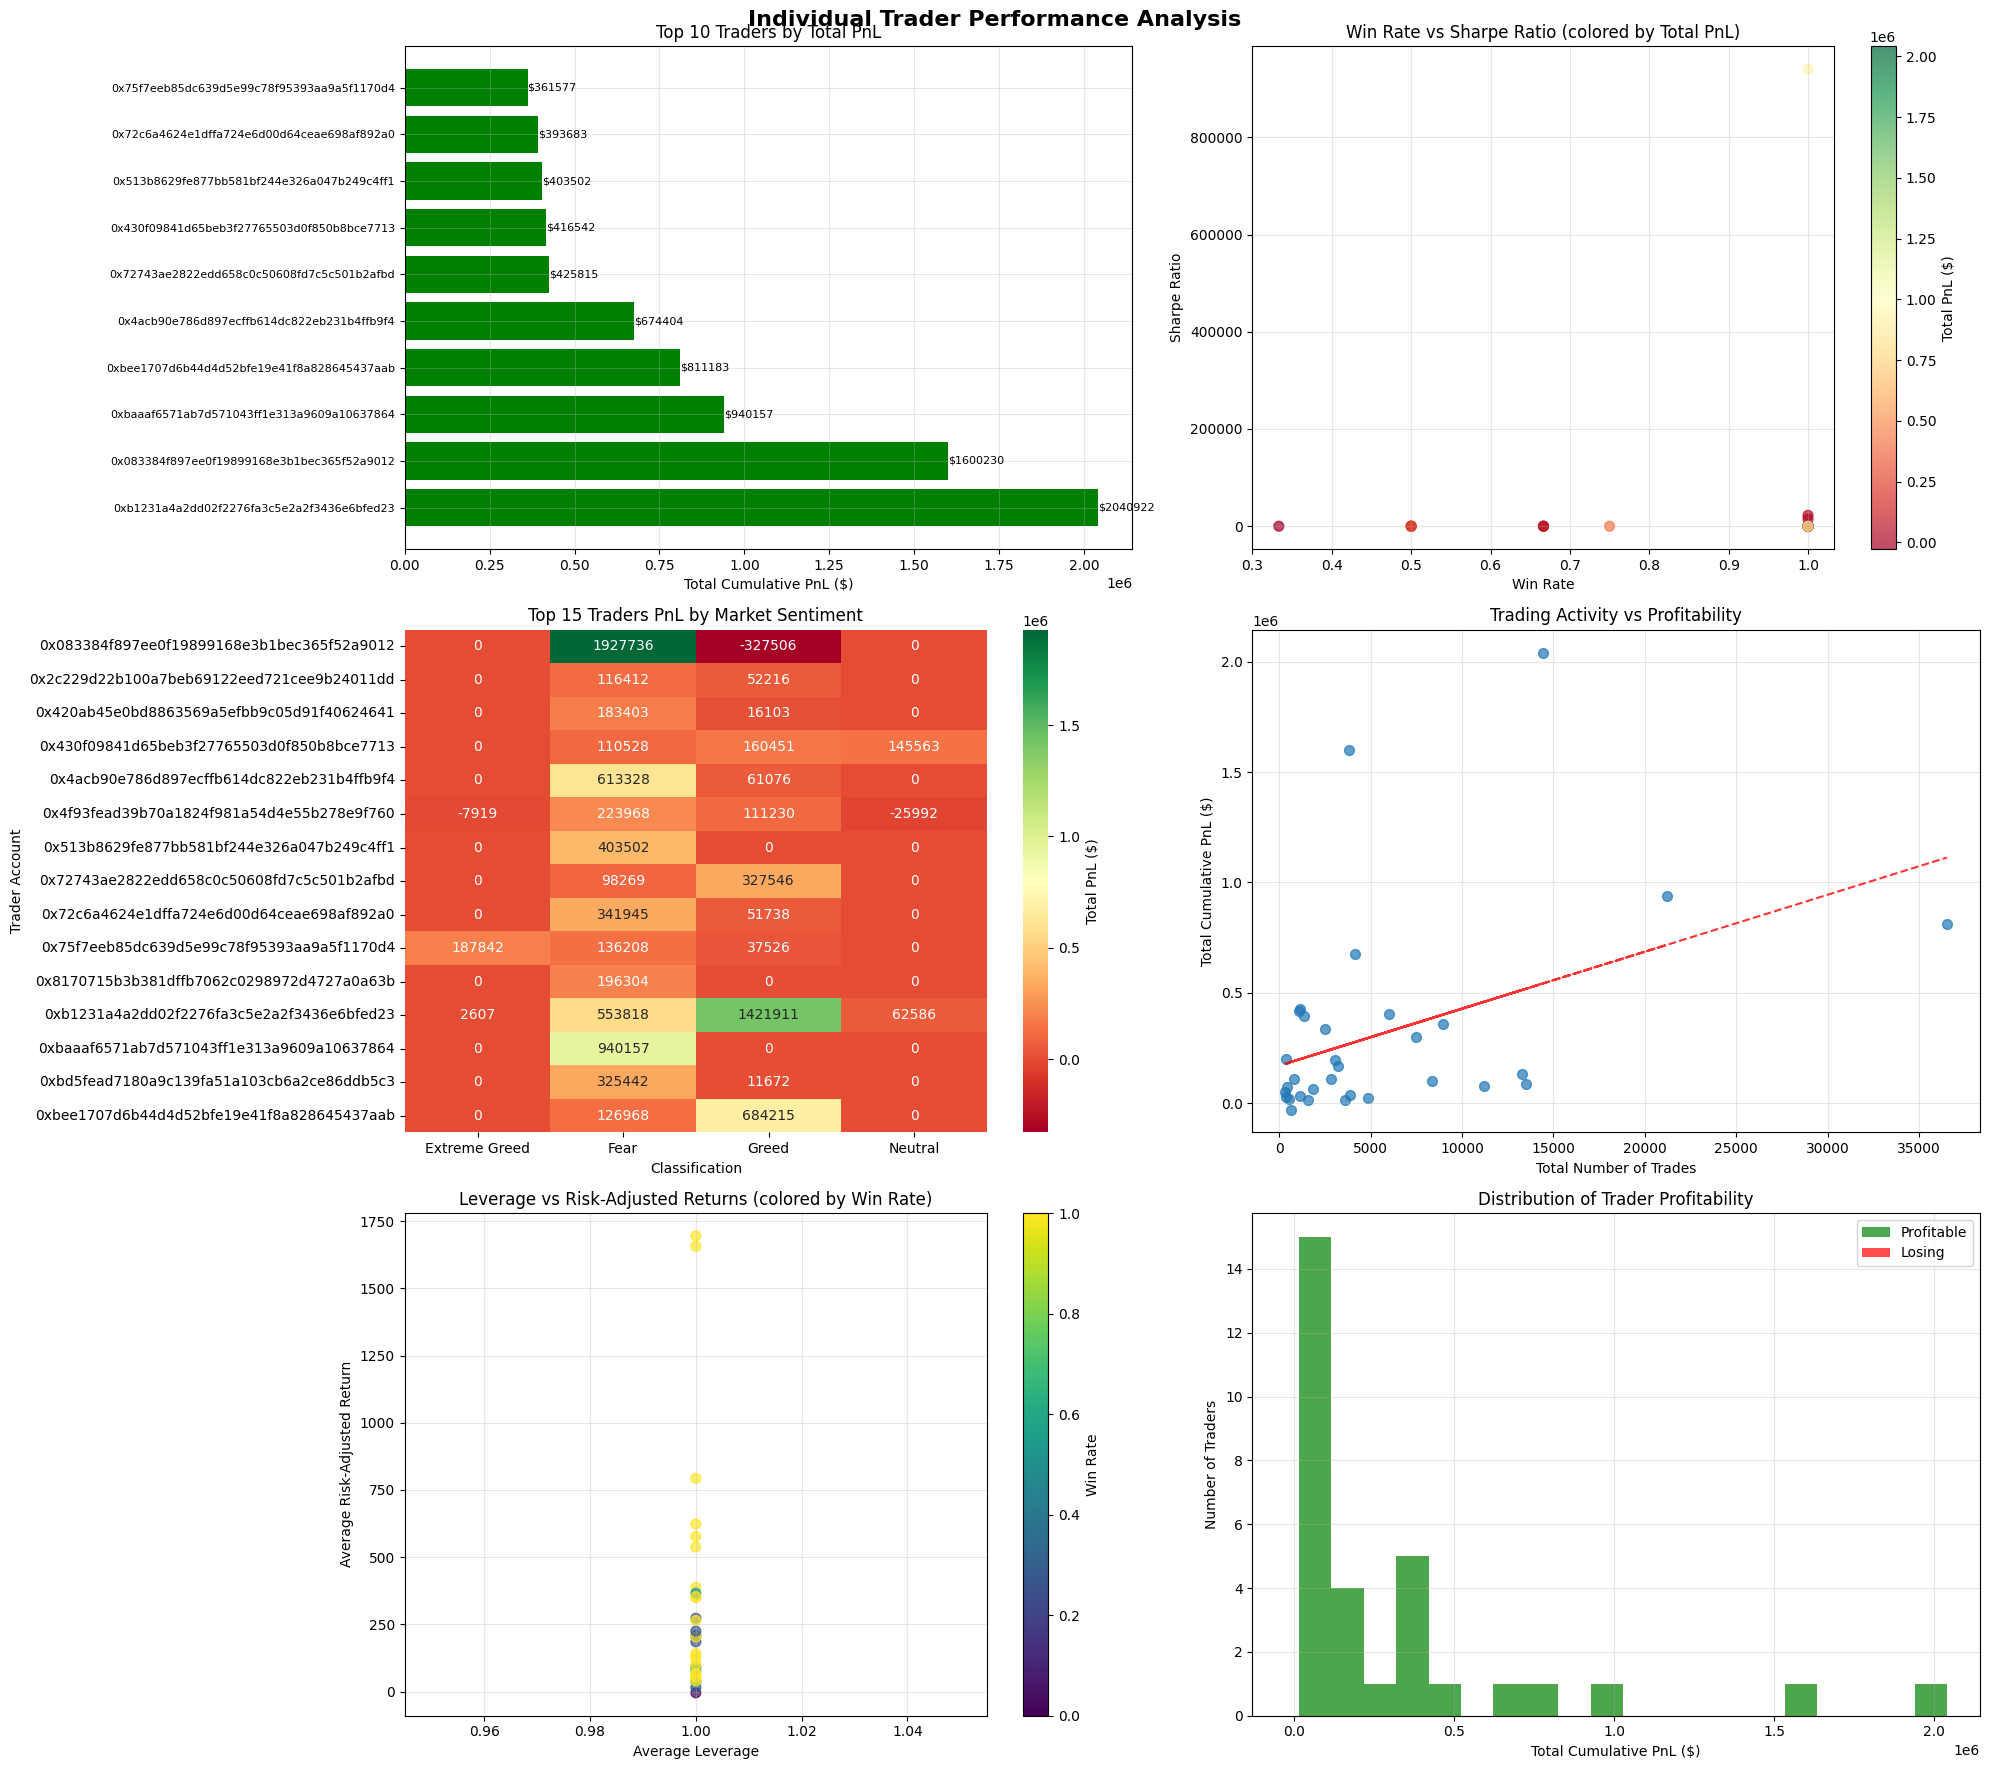


COMPREHENSIVE TRADING INSIGHTS REPORT

📊 KEY PERFORMANCE METRICS:
• Total trading sessions analyzed: 77
• Greed periods: 32 (41.6%)
• Fear periods: 32 (41.6%)
• Neutral periods: 8 (10.4%)
• Extreme Greed periods: 5 (6.5%)

💰 PROFITABILITY ANALYSIS:
• Average PnL during Greed: $99675.52
• Average PnL during Fear: $209372.66
• Average PnL during Neutral: $19842.80
• Average PnL during Extreme Greed: $35393.10

⚖️ RISK ANALYSIS:
• Win rate during Greed: 84.4%
• Average leverage during Greed: 1.00x
• Win rate during Fear: 93.8%
• Average leverage during Fear: 1.00x
• Win rate during Neutral: 50.0%
• Average leverage during Neutral: 1.00x
• Win rate during Extreme Greed: 40.0%
• Average leverage during Extreme Greed: 1.00x

📈 TRADING BEHAVIOR:
• Avg trades per day (Greed): 1134.0
• Avg trades per day (Fear): 4183.5
• Avg trades per day (Neutral): 892.6
• Avg trades per day (Extreme Greed): 1392.4

🎯 STRATEGIC RECOMMENDATIONS:
• Monitor sentiment as a key factor in trading decisions
• Adjus

In [48]:
def main():
    """Enhanced main execution function with individual trader analysis"""

    # Initialize analyzer
    analyzer = TradingSentimentAnalyzer()

    # File paths (update these with your actual file paths)
    trader_file = '/content/historical_data (1).csv'
    sentiment_file = '/content/fear_greed_index (1).csv'

    print("📁 Loading data from:")
    print(f"Trader file: {trader_file}")
    print(f"Sentiment file: {sentiment_file}")

    # Load and analyze data
    if analyzer.load_data(trader_file, sentiment_file):

        print("\n🔍 Starting comprehensive analysis...")

        # 1. Calculate trader metrics
        trader_metrics = analyzer.calculate_trader_metrics()

        if len(trader_metrics) == 0:
            print("❌ No trader metrics calculated. Check your data.")
            return None

        # 2. Merge with sentiment data
        merged_data = analyzer.merge_with_sentiment()

        if len(merged_data) == 0:
            print("❌ No overlapping data found. Analysis cannot continue.")
            print("Please check that your datasets have overlapping date ranges.")
            return analyzer

        # 3. Individual trader performance analysis (NEW)
        print("\n🏆 Analyzing individual trader performance...")
        individual_analysis = analyzer.analyze_individual_trader_performance()

        # 4. Trader performance by sentiment (NEW)
        print("\n🎭 Analyzing trader performance by sentiment...")
        sentiment_performance = analyzer.analyze_trader_performance_by_sentiment()

        # 5. Identify sentiment specialists (NEW)
        print("\n🎯 Identifying sentiment specialists...")
        specialists = analyzer.identify_trader_sentiment_specialists()

        # 6. Analyze sentiment impact (existing)
        sentiment_impact = analyzer.analyze_sentiment_impact()

        # 7. Identify trader clusters (existing, only if we have sufficient data)
        if len(merged_data) >= 4:
            trader_clusters, cluster_analysis = analyzer.identify_trader_clusters()
        else:
            print("⚠️ Insufficient data for clustering analysis")

        # 8. Create visualizations (existing)
        analyzer.create_visualizations()

        # 9. Create individual trader visualizations (NEW)
        if individual_analysis is not None and len(individual_analysis) > 0:
            analyzer.create_individual_trader_visualizations()

        # 10. Generate insights report (existing)
        analyzer.generate_insights_report()

        # 11. Generate individual trader report (NEW)
        analyzer.generate_individual_trader_report()

        print("\n✅ Enhanced analysis completed successfully!")
        print("\n📋 ANALYSIS SUMMARY:")
        print(f"• Total traders analyzed: {len(individual_analysis) if individual_analysis is not None else 0}")
        print(f"• Sentiment periods covered: {len(merged_data)}")
        print(f"• Individual trader metrics: ✅ Complete")
        print(f"• Sentiment-based performance: ✅ Complete")
        print(f"• Specialist identification: ✅ Complete")
        print(f"• Visualizations: ✅ Complete")

        return analyzer

    else:
        print("❌ Failed to load data. Please check file paths and try again.")
        return None


# Run the enhanced analysis
if __name__ == "__main__":
    analyzer = main()